## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader, random_split

cudnn.benchmark = True
plt.ion()

Load data and create Dataloaders

In [3]:
from utils import SymbolDataset, encode_labels

data_dir = 'symbols_2000.npz'
data = np.load(data_dir)
images = data['images']
labels = data['labels']

class_names, labels_nums = encode_labels(labels)

images_tensor = torch.tensor(images).float()

# NOTE: maybe try different mean and stds?
# mean and std from imagenet are as follows:
#  - mean = 0.4453
#  - std  = 0.2692

# Calculate the mean and standard deviation
mean = images_tensor.mean()
std = images_tensor.std()

data_transforms = {
    'train': transforms.Compose([ # Add in transforms if needed, and add test set
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
}

# initialize symbol dataset training splits
dataset = SymbolDataset(images, labels_nums, transforms=data_transforms['train'])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# initialize dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)
}
dataset_sizes = {x: len(dataset) for x in ['train', 'val']}
class_names = np.unique(labels)
num_classes = len(class_names)
print(num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

26


Visualize a batch of training data

torch.Size([3, 274, 274])


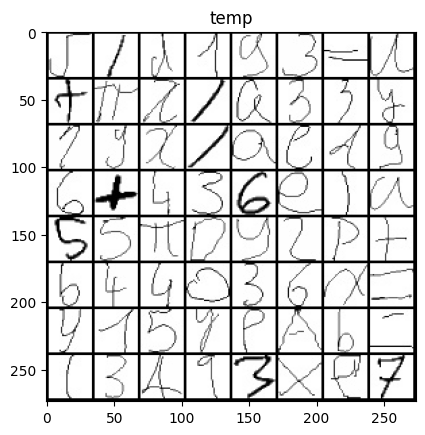

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title="temp")

## Model Training

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    if torch.cuda.is_available():
        model = model.cuda()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        train_loss = []
        val_loss = []
        val_acc = [] 

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                count = 0
                for inputs, labels in dataloaders[phase]:
                    inputs = np.repeat(inputs, 3, axis=1)
                    count += len(labels)
                    if torch.cuda.is_available():
                        inputs = inputs.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / count
                epoch_acc = running_corrects.double() / count

                if phase == 'train':
                    train_loss.append(epoch_loss)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc.cpu().numpy())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Train Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend()
        plt.grid()

        plt.show()

    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # if it errors here u probably have to do the same grayscale to rgb stacking i did earlier
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.repeat(1, 3, 1, 1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Summarize pre-trained ResNet18

In [7]:
from torchinfo import summary

model_ft = models.resnet18(weights='IMAGENET1K_V1')
summary(model=model_ft, 
        verbose=0,
        input_size=(64, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 1000]           --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 16, 16]     9,408                True
├─BatchNorm2d (bn1)                      [64, 64, 16, 16]     [64, 64, 16, 16]     128                  True
├─ReLU (relu)                            [64, 64, 16, 16]     [64, 64, 16, 16]     --                   --
├─MaxPool2d (maxpool)                    [64, 64, 16, 16]     [64, 64, 8, 8]       --                   --
├─Sequential (layer1)                    [64, 64, 8, 8]       [64, 64, 8, 8]       --                   True
│    └─BasicBlock (0)                    [64, 64, 8, 8]       [64, 64, 8, 8]       --                   True
│    │    └─Conv2d (conv1)               [64, 64, 8, 8]       [64, 64, 8, 8]       36,864               True
│    │    └─BatchN

Modify last linear classification layer and freeze previous layers in preparation for transfer learning

In [8]:
for param in model_ft.parameters():
    param.requires_grad = False

# alter output size of last linear layer (fc)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

summary(model=model_ft, 
        verbose=0,
        input_size=(64, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 26]             --                   Partial
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 16, 16]     (9,408)              False
├─BatchNorm2d (bn1)                      [64, 64, 16, 16]     [64, 64, 16, 16]     (128)                False
├─ReLU (relu)                            [64, 64, 16, 16]     [64, 64, 16, 16]     --                   --
├─MaxPool2d (maxpool)                    [64, 64, 16, 16]     [64, 64, 8, 8]       --                   --
├─Sequential (layer1)                    [64, 64, 8, 8]       [64, 64, 8, 8]       --                   False
│    └─BasicBlock (0)                    [64, 64, 8, 8]       [64, 64, 8, 8]       --                   False
│    │    └─Conv2d (conv1)               [64, 64, 8, 8]       [64, 64, 8, 8]       (36,864)             False
│    │    

Initialize loss criterion and training optimizer

In [9]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training loop

Epoch 0/24
----------
train Loss: 1.8617 Acc: 0.5017
val Loss: 1.3703 Acc: 0.6409

Epoch 1/24
----------
train Loss: 1.3346 Acc: 0.6339
val Loss: 1.1788 Acc: 0.6768

Epoch 2/24
----------
train Loss: 1.2123 Acc: 0.6614
val Loss: 1.1137 Acc: 0.6922

Epoch 3/24
----------
train Loss: 1.1459 Acc: 0.6754
val Loss: 1.0578 Acc: 0.7098

Epoch 4/24
----------
train Loss: 1.0989 Acc: 0.6880
val Loss: 1.0335 Acc: 0.7151

Epoch 5/24
----------
train Loss: 1.0703 Acc: 0.6946
val Loss: 1.0043 Acc: 0.7197

Epoch 6/24
----------
train Loss: 1.0445 Acc: 0.7019
val Loss: 1.0061 Acc: 0.7205

Epoch 7/24
----------
train Loss: 1.0233 Acc: 0.7074
val Loss: 0.9742 Acc: 0.7330

Epoch 8/24
----------
train Loss: 1.0185 Acc: 0.7095
val Loss: 0.9716 Acc: 0.7323

Epoch 9/24
----------
train Loss: 1.0222 Acc: 0.7079
val Loss: 0.9654 Acc: 0.7303

Epoch 10/24
----------
train Loss: 1.0203 Acc: 0.7075
val Loss: 0.9799 Acc: 0.7276

Epoch 11/24
----------
train Loss: 1.0150 Acc: 0.7096
val Loss: 0.9735 Acc: 0.7332

Ep

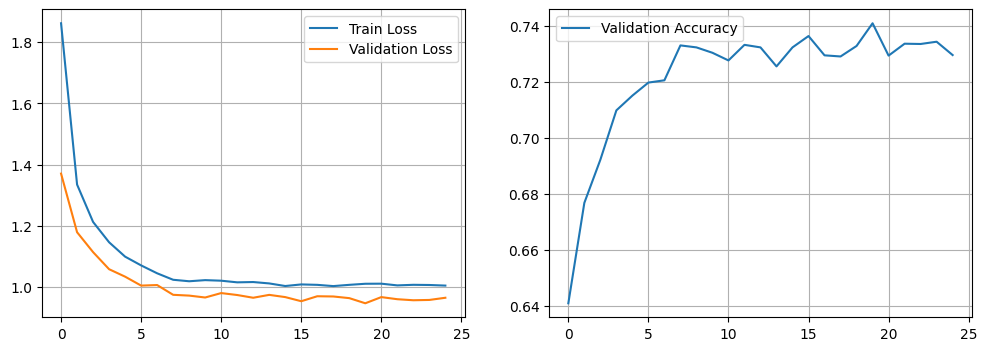

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Model Visualization

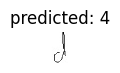

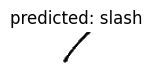

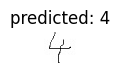

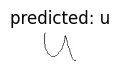

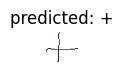

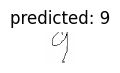

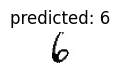

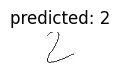

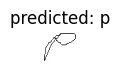

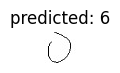

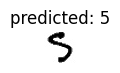

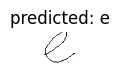

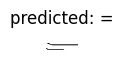

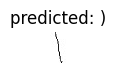

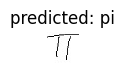

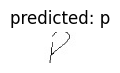

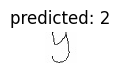

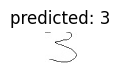

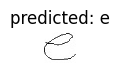

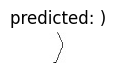

In [11]:
visualize_model(model_ft, 20)

In [12]:
torch.save(model_ft, 'transfer_model_resnet18.pth')